# Step 1: Identifying Potential Xylanase Sequences
In this step, We will:
1. Install and configure BLAST+
2. Download the reference thermostable xylanase sequences
3. Run BLAST to find similar sequences
4. Extract significant hits

### 1. Install BLAST+ (if not already installed)

In [1]:
!conda install -c bioconda blast -y

Channels:
 - bioconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.



### 2. Download Reference Xylanase Sequences
Download the reference xylanase sequences from the provided Google Drive link. We have already downloaded the dataset manually.

In [ ]:
!pip install gdown
!gdown --id 1-dDyIdAXKUK97rxw_n4zE_gzh2fztFRU

### 3. Format the Reference Database

In [7]:
!makeblastdb -in data/thermo_xylanase.fasta -dbtype prot -out xylanase_db



Building a new DB, current time: 02/07/2025 18:52:31
New DB name:   /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
New DB title:  data/thermo_xylanase.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 11 sequences in 0.000927925 seconds.




### 3.1 Run BLASTN to Identify Similar Contigs


In [8]:
# !blastx -query data/y5.final.contigs.fa -db xylanase_db -out step1/blast_results.txt -evalue 1e-5 -outfmt 6

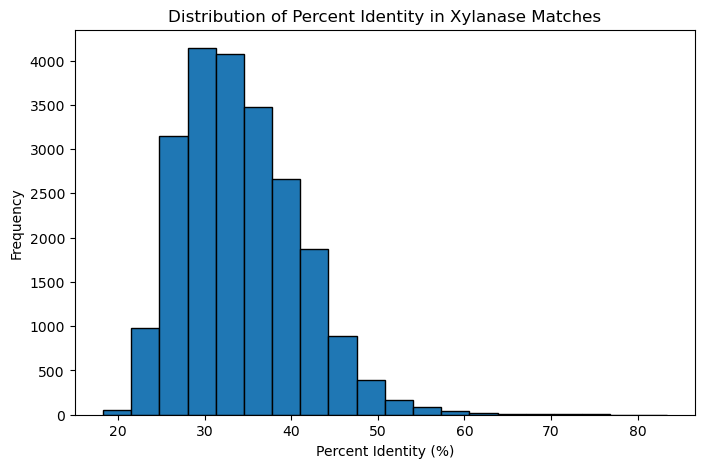

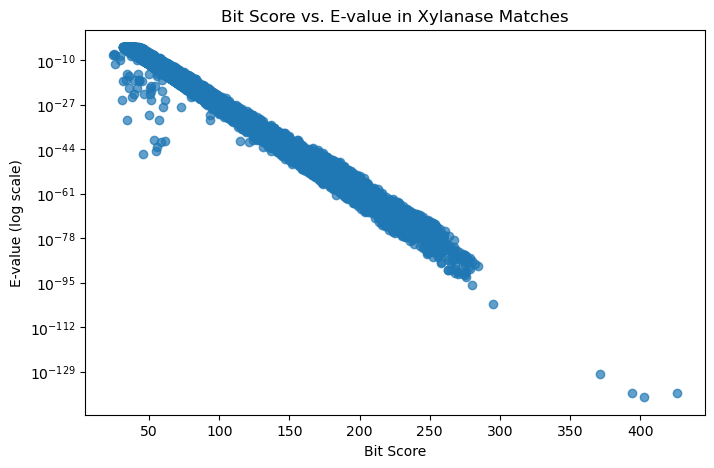

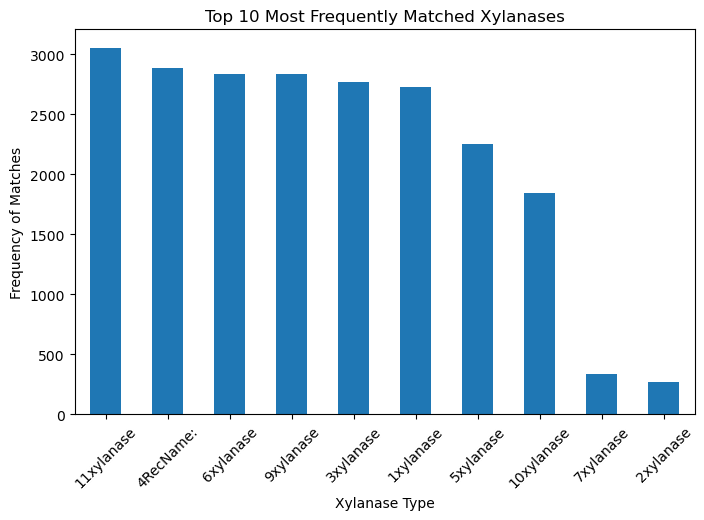

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the provided results.txt
file_path = "step1/blast_results.txt"

# Define column names based on BLAST-like output format
columns = ["Contig", "Matched_Xylanase", "Percent_Identity", "Alignment_Length", "Mismatches",
           "Gap_Openings", "Query_Start", "Query_End", "Subject_Start", "Subject_End",
           "E_value", "Bit_Score"]

# Read the data
df = pd.read_csv(file_path, sep="\t", names=columns)

# Convert necessary columns to numeric types
df["Percent_Identity"] = pd.to_numeric(df["Percent_Identity"], errors='coerce')
df["E_value"] = pd.to_numeric(df["E_value"], errors='coerce')
df["Bit_Score"] = pd.to_numeric(df["Bit_Score"], errors='coerce')


# Plot 1: Distribution of Percent Identity
plt.figure(figsize=(8, 5))
plt.hist(df["Percent_Identity"], bins=20, edgecolor='black')
plt.xlabel("Percent Identity (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Percent Identity in Xylanase Matches")
plt.savefig("images/percent_identity_dist.png")
plt.show()

# Plot 2: Scatter plot of Bit Score vs. E-value (log scale)
plt.figure(figsize=(8, 5))
plt.scatter(df["Bit_Score"], df["E_value"], alpha=0.7)
plt.yscale("log")  # Log scale for better visibility
plt.xlabel("Bit Score")
plt.ylabel("E-value (log scale)")
plt.title("Bit Score vs. E-value in Xylanase Matches")
plt.savefig("images/bit_score_evalue.png")
plt.show()

# Plot 3: Most Frequently Matched Xylanases
top_xylanases = df["Matched_Xylanase"].value_counts().head(10)
plt.figure(figsize=(8, 5))
top_xylanases.plot(kind="bar")
plt.xlabel("Xylanase Type")
plt.ylabel("Frequency of Matches")
plt.title("Top 10 Most Frequently Matched Xylanases")
plt.xticks(rotation=45)
plt.savefig("images/top_matches.png")
plt.show()


### 3.2. DIAMOND BLASTX (Faster than BLAST)

In [ ]:
!conda install -c bioconda diamond -y

In [126]:
!diamond makedb --in data/thermo_xylanase_aligned.fasta -d xylanase_db

diamond v2.1.10.164 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 12
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/thermo_xylanase_aligned.fasta
Opening the database file...  [0s]
Loading sequences...  [0s]
Masking sequences...  [0.003s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  11
  Database letters  12408
     Database hash  ef7b5b85c1b882aac3ffeae765bc68e7
        Total time  0.005000s


In [129]:
!diamond blastx -d xylanase_db.dmnd -q data/y5.final.contigs.fa -o step1/diamond_output.tsv --outfmt 6 --sensitive --evalue 1e-5

diamond v2.1.10.164 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 12
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: step1
#Target sequences to report alignments for: 25
Opening the database...  [0s]
Database: xylanase_db.dmnd (type: Diamond database, sequences: 11, letters: 12408)
Block size = 2000000000
Opening the input file...  [0.091s]
Opening the output file...  [0s]
Loading query sequences... 

### 3.3. HMMER Search (Profile-based Similarity)
HMMER uses profile Hidden Markov Models (HMMs), which are better for detecting remote homologs.
It looks like there may be invalid characters in the FASTA sequence. I'll clean the file by Removing any tab characters, Removing empty lines, Ensuring only valid amino acid characters are used.

In [ ]:
# import re
# 
# # Define valid amino acid characters and allowed symbols
# valid_chars = re.compile(r"^[ACDEFGHIKLMNPQRSTVWYBXZ\-]+$")
# 
# # Clean the FASTA file
# cleaned_fasta = []
# for line in fasta_content:
#     line = line.strip()  # Remove leading/trailing whitespace
#     if line.startswith(">"):  # Keep headers unchanged
#         cleaned_fasta.append(line)
#     elif line:  # Ignore empty lines
#         # Remove invalid characters (e.g., tabs) and check sequence validity
#         line = line.replace("\t", "").upper()
#         if valid_chars.match(line):
#             cleaned_fasta.append(line)
#         else:
#             print(f"Warning: Skipping line due to invalid characters - {line}")
# 
# # Save the cleaned file
# cleaned_file_path = "data/thermo_xylanase_cleaned.fasta"
# with open(cleaned_file_path, "w") as f:
#     f.write("\n".join(cleaned_fasta) + "\n")

HMMER expects an aligned FASTA file (i.e., all sequences should be of equal length)

In [24]:
!clustalo -i data/thermo_xylanase_cleaned.fasta -o data/thermo_xylanase_aligned.fasta --force

Now, First, we create an HMM profile from our known sequences:

In [25]:
!hmmbuild xylanase.hmm data/thermo_xylanase_aligned.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             data/thermo_xylanase_aligned.fasta
# output HMM file:                  xylanase.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     thermo_xylanase_aligned    11  1128   799     2.15  0.589 

# CPU time: 0.32u 0.00s 00:00:00.32 Elapsed: 00:00:00.32


Now, search the contigs against this HMM model:

Since hmmsearch cannot handle long sequences, we need to break the y5.final.contigs.fa file into smaller chunks before running hmmsearch. We can use seqkit for this.

In [28]:
!seqkit sliding -s 50000 -W 50000 -o data/y5_splitted.fa data/y5.final.contigs.fa

Searches for xylanase-like sequences in the split metagenomic contigs.

In [32]:
!hmmsearch --tblout step1/hmm_results.txt xylanase.hmm data/y5_splitted.fa

Failed to parse command line: No such option "--E".
Usage: hmmsearch [options] <hmmfile> <seqdb>

where most common options are:
  -h : show brief help on version and usage

To see more help on available options, do hmmsearch -h



### 4. Filter Results Based on Similarity
After running all three searches, we extract contigs that have significant similarity. From now on, we just use the results of BLAST+.

In [13]:
import pandas as pd

# Load BLASTX results (assuming the file is tab-separated)
blastx_df = pd.read_csv("step1/blast_results.txt", sep="\t", header=None)

# Assign column names based on BLASTX output format
blastx_df.columns = ["Query_ID", "Subject_ID", "%_Identity", "Alignment_Length", 
                     "Mismatches", "Gap_Openings", "Query_Start", "Query_End", 
                     "Subject_Start", "Subject_End", "E-value", "Bit_Score"]
# Define thresholds
identity_threshold = 30   # Keep sequences with at least 30% identity
alignment_length_threshold = 50  # Keep sequences with at least 50 aligned amino acids
evalue_threshold = 1e-5   # Remove weak matches (higher E-value means lower significance)
bit_score_threshold = 50  # Keep strong alignments

# Apply filtering
filtered_df = blastx_df[
    (blastx_df["%_Identity"] >= identity_threshold) &
    (blastx_df["Alignment_Length"] >= alignment_length_threshold) &
    (blastx_df["E-value"] <= evalue_threshold) &
    (blastx_df["Bit_Score"] >= bit_score_threshold)
]

# Save filtered results
filtered_df.to_csv("step1/filtered_results.txt", sep="\t", index=False)

### 5. Extract & Translate Candidate Contigs

In [14]:
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq

# Load the filtered BLASTX results
filtered_blastx_df = pd.read_csv("step1/filtered_results.txt", sep="\t")

# Extract the contig IDs that passed the filtering
filtered_contigs = set(filtered_blastx_df["Query_ID"])  # Unique contig IDs

#### Extract Nucleotide Sequences from Dataset

In [16]:
# Load the assembled contigs file (nucleotide sequences)
contig_file = "data/y5.final.contigs.fa"  # Change this to your actual filename

# Read the nucleotide sequences and store only the filtered ones
filtered_sequences = {}

for record in SeqIO.parse(contig_file, "fasta"):
    if record.id in filtered_contigs:  # Keep only sequences that passed filtering
        filtered_sequences[record.id] = record.seq

# Save extracted sequences to a new FASTA file
with open("step1/filtered_contigs.fasta", "w") as output_fasta:
    for contig_id, seq in filtered_sequences.items():
        output_fasta.write(f">{contig_id}\n{seq}\n")


#### Translate Nucleotide Sequences to Protein

In [19]:
# Translate the filtered nucleotide sequences
translated_sequences = {}

for contig_id, seq in filtered_sequences.items():
    translated_seq = Seq(str(seq)).translate(to_stop=True)  # Stop at first stop codon
    translated_sequences[contig_id] = translated_seq

# Save translated sequences to a FASTA file
with open("step1/translated_proteins.fasta", "w") as output_fasta:
    for contig_id, protein_seq in translated_sequences.items():
        output_fasta.write(f">{contig_id}\n{protein_seq}\n")

/home/amir/miniconda3/lib/python3.12/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


#### Using Commands
Also, We can do it using the Seqtk and TRANSEQ 

In [23]:
!conda install -c bioconda seqtk -y

Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/amir/miniconda3

  added / updated specs:
    - seqtk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seqtk-1.4                  |       he4a0461_2          43 KB  bioconda
    ------------------------------------------------------------
                                           Total:          43 KB

The following NEW packages will be INSTALLED:

  seqtk              bioconda/linux-64::seqtk-1.4-he4a0461_2 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
# Extract potential contig sequences
!seqtk subseq data/y5.final.contigs.fa step1/filtered_results.txt > step1/potential_xylanase_contigs.fasta

In [29]:
!conda install -c bioconda emboss -y

Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/amir/miniconda3

  added / updated specs:
    - emboss


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    emboss-6.6.0               |       h6debe1e_0        94.5 MB  bioconda
    libgd-2.3.3                |       h695aa2c_1         222 KB
    ------------------------------------------------------------
                                           Total:        94.7 MB

The following NEW packages will be INSTALLED:

  emboss             bioconda/linux-64::emboss-6.6.0-h6debe1e_0 
  libgd              pkgs/main/linux-64::libgd-2.3.3-h695aa2c_1 



emboss-6.6.0         | 94.5 MB   |                                       |   0% 
libgd-2.3.3          | 222 KB    |                                       |   0% 
libgd-2.3.3          | 222 KB    | ##6                  

In [6]:
# Translate contigs into protein sequences
!transeq step1/potential_xylanase_contigs.fasta -outseq step1/potential_xylanase_proteins.fa

Translate nucleic acid sequences


In [36]:
from Bio import SeqIO

# Load the extracted sequences
extracted_sequences = list(SeqIO.parse("step1/potential_xylanase_contigs.fasta", "fasta"))

# Display the first few sequences
for i, record in enumerate(extracted_sequences[:5]):  # Display first 5 sequences
    print(f"Sequence ID: {record.id}")
    print(f"Sequence: {record.seq}")
    print(f"Length: {len(record.seq)}")
   

Sequence ID: k141_960819:12-44
Sequence: TGAAATAAAAGGTGATTCTAGTACTGTTGATGA
Length: 33
Sequence ID: k141_3842622:12-34
Sequence: GGGAGGCTCAGCACGACTGATTT
Length: 23
Sequence ID: k141_3842622:10-30
Sequence: CTGGGAGGCTCAGCACGACTG
Length: 21
Sequence ID: k141_3842622:5-32
Sequence: CTTTGCTGGGAGGCTCAGCACGACTGAT
Length: 28
Sequence ID: k141_3842622:2-30
Sequence: ATGCTTTGCTGGGAGGCTCAGCACGACTG
Length: 29


#### (Optional) Machine learning-based approach


In [ ]:
# !pip install scikit-learn biopython
# from Bio import SeqIO
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# known_xylanases = list(SeqIO.parse("thermo_xylanase.fasta", "fasta"))
# known_sequences = [str(record.seq) for record in known_xylanases]
# vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))
# X_known = vectorizer.fit_transform(known_sequences)
# potential_sequences = list(SeqIO.parse("potential_xylanase_proteins.fa", "fasta"))
# potential_sequences = [str(record.seq) for record in potential_sequences]
# X_potential = vectorizer.transform(potential_sequences)
# from sklearn.linear_model import LogisticRegression
# y_known = np.ones(len(known_sequences))
# model = LogisticRegression()
# model.fit(X_known, y_known)
# predictions = model.predict(X_potential)
# predicted_xylanases = [potential_sequences[i] for i in range(len(potential_sequences)) if predictions[i] == 1]
# with open("predicted_xylanase_sequences.fa", "w") as f:
#     for i, seq in enumerate(predicted_xylanases):
#         f.write(f">predicted_xylanase_{i}\n{seq}\n")